In [1]:
import pandas as pd
from utils.vitals import analyze_vitals, resp_orient

import numpy as np
import pandas as pd
from scipy import signal
from utils.general import bandpass_filt, shannon_energy, label_dataframe, read_edf, plot_labeled_dataframe
from scipy import ndimage

import matplotlib.pyplot as plt
import docx
import matplotlib.patches as mpatches

In [2]:
test_path = r'../rawdata/ma01raw.parquet'
df = pd.read_parquet(test_path)
df
# df.index = pd.to_datetime(df.index)

,t,x,y,z
0,2023-04-18 01:53:05.053474,330,-8212,758
1,2023-04-18 01:53:05.054082,329,-8212,799
2,2023-04-18 01:53:05.054690,329,-8212,793
3,2023-04-18 01:53:05.055298,329,-8212,750
4,2023-04-18 01:53:05.055906,329,-8212,757
...,...,...,...,...
51542475,2023-04-19 01:25:08.470412,-709,-518,8121
51542476,2023-04-19 01:25:08.471025,-709,-518,8104
51542477,2023-04-19 01:25:08.471638,-709,-518,8115
51542478,2023-04-19 01:25:08.472251,-709,-518,8086


In [3]:
# def test_analyze_vitals(path, shift=0):
extension = test_path.split('.')[-1]
if extension == 'csv':
    print('reading csv file')
    df = pd.read_csv(test_path)[['ts', 'x', 'y', 'z']].rename({'ts':'t'})
else:
    print('reading parquet file')
    df = pd.read_parquet(test_path, engine='pyarrow')[['t', 'x', 'y', 'z']]

df.set_index('t', inplace=True)

df_down = df.resample('1ms').mean().dropna()
fs = 1e-09**-1/np.median(np.diff(df_down.index.values.astype(np.int64)))



    # return ret.shift(shift)

reading parquet file


In [4]:

# Calculating HR from MA Z signals
ma_z_lp = bandpass_filt(df_down['z'].to_frame(), 1/0.05, fs, 'lowpass')
ma_z_bp = bandpass_filt(ma_z_lp, (20, 51), fs, 'bandpass')

ma_z_bp_cwt = signal.cwt(ma_z_bp['z'].values.T,signal.morlet,np.arange(1,20))
ma_z_cwt_pk = ma_z_bp_cwt.T[:,1:15]
cwt_pks = ma_z_cwt_pk.max(axis=1)


# Shannon energy followed by gaussian_filter on absolute values of shannon energy
cwt_se = shannon_energy(cwt_pks)
cwt_se_gs = ndimage.gaussian_filter(np.abs(cwt_se),sigma=25)
cwt_se_gs = pd.DataFrame({'z':cwt_se_gs}, index=df_down.index)
single_peak = bandpass_filt(cwt_se_gs, 1/0.7, fs, 'lowpass')
peaks, _ = signal.find_peaks(single_peak.values.T[0],height=2e-7,distance=350)
peak_intervals = np.diff(peaks) / fs

# Dynamic HR calculation

heart_rates = 60 / peak_intervals
hr_df = pd.DataFrame({'ma_hr':heart_rates}, index=df_down.index[peaks[:-1]])

hr_df = bandpass_filt(hr_df, 50, 1000, 'lowpass')
hr_df['ma_rr_interval'] = hr_df['ma_hr']/60

ds_for_orient = df_down.resample('100ms').mean().fillna(method='ffill').fillna(method='bfill')


In [17]:
def dot_product(row):
    index = row.name
    if index == df.index[0]:  # Skip the first row
        return np.nan
    prev_row = df.loc[df.index[df.index.get_loc(index) - 1]]
    return np.dot(row[['X', 'Y', 'Z']], prev_row[['X', 'Y', 'Z']])

In [19]:
ds_for_orient.apply(dot_product, axis=1)

KeyError: Timestamp('2023-04-18 01:53:05')

In [9]:
# print('start computing')
# phi, _ = resp_orient(ds_for_orient.values.T, fs)
# phi = pd.DataFrame({'resp_orientation':phi}, index=ds_for_orient.index)

# phi = phi.resample('1ms').interpolate(method='linear')
# print('end computing')
# rr_single_peak = bandpass_filt(phi, np.array([0.05, 0.4]), 1000, 'bandpass')

# rr_peaks, _ = signal.find_peaks(rr_single_peak.values.T[0],height=-0.05, distance=1000)

# rr_peak_intervals = np.diff(rr_peaks) / fs


# # Dynamic HR calculation

# respiration_rate = 60 / rr_peak_intervals
# respiration_rate = pd.DataFrame({'ma_rr':respiration_rate}, index=rr_single_peak.index[rr_peaks[:-1]])
# ret = pd.concat([df_down, hr_df, phi, respiration_rate], axis=1).fillna(method='ffill').fillna(method='bfill')
# ret.index = ret.index - pd.Timedelta(hours=5)

start computing


d:\ShiyuanDuan\SleepStudy\MA_sleep\utils\vitals.py:100: RuntimeWarning: invalid value encountered in arccos
  theta = np.array([np.arccos(np.dot(a[:,i+1],a[:,i])) for i in range(n[1]-1)])


In [4]:
ma_df = test_analyze_vitals(test_path)
ma_df

reading parquet file


d:\ShiyuanDuan\SleepStudy\MA_sleep\utils\vitals.py:100: RuntimeWarning: invalid value encountered in arccos
  theta = np.array([np.arccos(np.dot(a[:,i+1],a[:,i])) for i in range(n[1]-1)])


In [ ]:
edf_df = read_edf('../rawdata/yd001.edf')

Extracting EDF parameters from d:\ShiyuanDuan\SleepStudy\rawdata\yd005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


d:\ShiyuanDuan\SleepStudy\MA_sleep\utils\general.py:78: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(path)
d:\ShiyuanDuan\SleepStudy\MA_sleep\utils\general.py:78: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)


In [ ]:
edf_ma = pd.concat([ma_df, edf_df], axis=1)
edf_ma

,x,y,z,ma_hr,resp_orientation,ma_rr,PR,RR
2023-04-18 22:59:35.000,-112.0,802.5,8168.5,77.952792,0.028353,19.646365,NaN,NaN
2023-04-18 22:59:35.001,-112.0,802.5,8168.5,77.952792,0.028345,19.646365,NaN,NaN
2023-04-18 22:59:35.002,-112.0,802.5,8168.5,77.952792,0.028337,19.646365,NaN,NaN
2023-04-18 22:59:35.003,-112.0,802.5,8168.5,77.952792,0.028329,19.646365,NaN,NaN
2023-04-18 22:59:35.004,-112.0,802.5,8168.5,77.952792,0.028321,19.646365,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-04-19 05:35:23.288,688.0,805.0,-8148.5,73.107888,-1.208324,15.898251,NaN,NaN
2023-04-19 05:35:23.289,688.0,805.0,-8189.0,73.107888,-1.208324,15.898251,NaN,NaN
2023-04-19 05:35:23.290,688.0,805.0,-8180.5,73.107888,-1.208324,15.898251,NaN,NaN
2023-04-19 05:35:23.291,688.0,805.0,-8137.0,73.107888,-1.208324,15.898251,NaN,NaN


In [6]:
# from datetime import datetime
doc_path = '../rawdata/yd005_STAGING.docx'
final_df = label_dataframe(edf_ma, doc_path)


In [21]:
def test_plot_labeled_dataframe(df):
    # reversed_label_map = {value: key for key, value in label_map.items()}

    fig, ax = plt.subplots(2, figsize=(30, 20))
    color_map = {'<Stage>Wake':'red', '<Stage>NREM 1':'green', '<Stage>NREM 2':'blue', '<Stage>NREM 3': 'orange', '<Stage>REM':'black', '<Stage>-': 'lavender', '<Stage>UNS':'purple'}
    legend_patches = []
    # for i in range(len(stage_index[:-1])):
    #     ax.axvspan(stage_index[i], stage_index[i + 1], facecolor=color_map[final_df['QuantizedStage'][stage_index[i]]], alpha=0.5)
    start_idx = 0
    for i, label in enumerate(df['Stage']):
        if i == 0:
            continue
        if df['Stage'][i] != df['Stage'][i - 1]:
            ax[0].axvspan(df.index[start_idx], df.index[i], facecolor=color_map[df['Stage'][i - 1]], alpha=0.5)
            ax[1].axvspan(df.index[start_idx], df.index[i], facecolor=color_map[df['Stage'][i - 1]], alpha=0.5)
            start_idx = i

    for k, v in color_map.items():
        legend_patches.append(mpatches.Patch(color=v, label=k, alpha=0.5))
    ax[0].plot(df.index, df['PR'], label='Heart Rate', color='black', linewidth=2)
    ax[0].plot(df.index, df['ma_hr'], label='MA Heart Rate', color='cyan', linewidth=1)
    ax[0].set_xlabel('Time(Month-Day Hour)', fontsize=24)
    ax[0].set_ylabel('Heart Rate', fontsize=24)
    ax[0].set_title('Heart Rate with Sleep Stage Labels', fontsize=36)
    ax[0].set_ylim(0, 120)
    # Add the legend with custom patches
    ax[0].legend(handles=list(set(legend_patches + [mpatches.Patch(color='black', label='Heart Rate'),mpatches.Patch(color='cyan', label='MA Heart Rate')])), loc='upper left', bbox_to_anchor=(1, 1), fontsize=24)

    
    ax[1].plot(df.index, df['RR'], label='EDF Respiration Rate', color='black', linewidth=2)
    ax[1].plot(df.index, df['ma_rr'], label='MA Respiration Rate', color='cyan', linewidth=1)
    ax[1].set_xlabel('Time(Month-Day Hour)', fontsize=24)
    ax[1].set_ylabel('Heart Rate', fontsize=24)
    ax[1].set_ylim(0, 120)
    ax[1].set_title('Respiration Rate with Sleep Stage Labels', fontsize=36)
    # ax[1].set_ylim(0, 40)
    ax[1].legend(handles=list(set(legend_patches + [mpatches.Patch(color='black', label='Heart Rate'),mpatches.Patch(color='cyan', label='MA Heart Rate')])), loc='upper left', bbox_to_anchor=(1, 1), fontsize=24)


    plt.show()

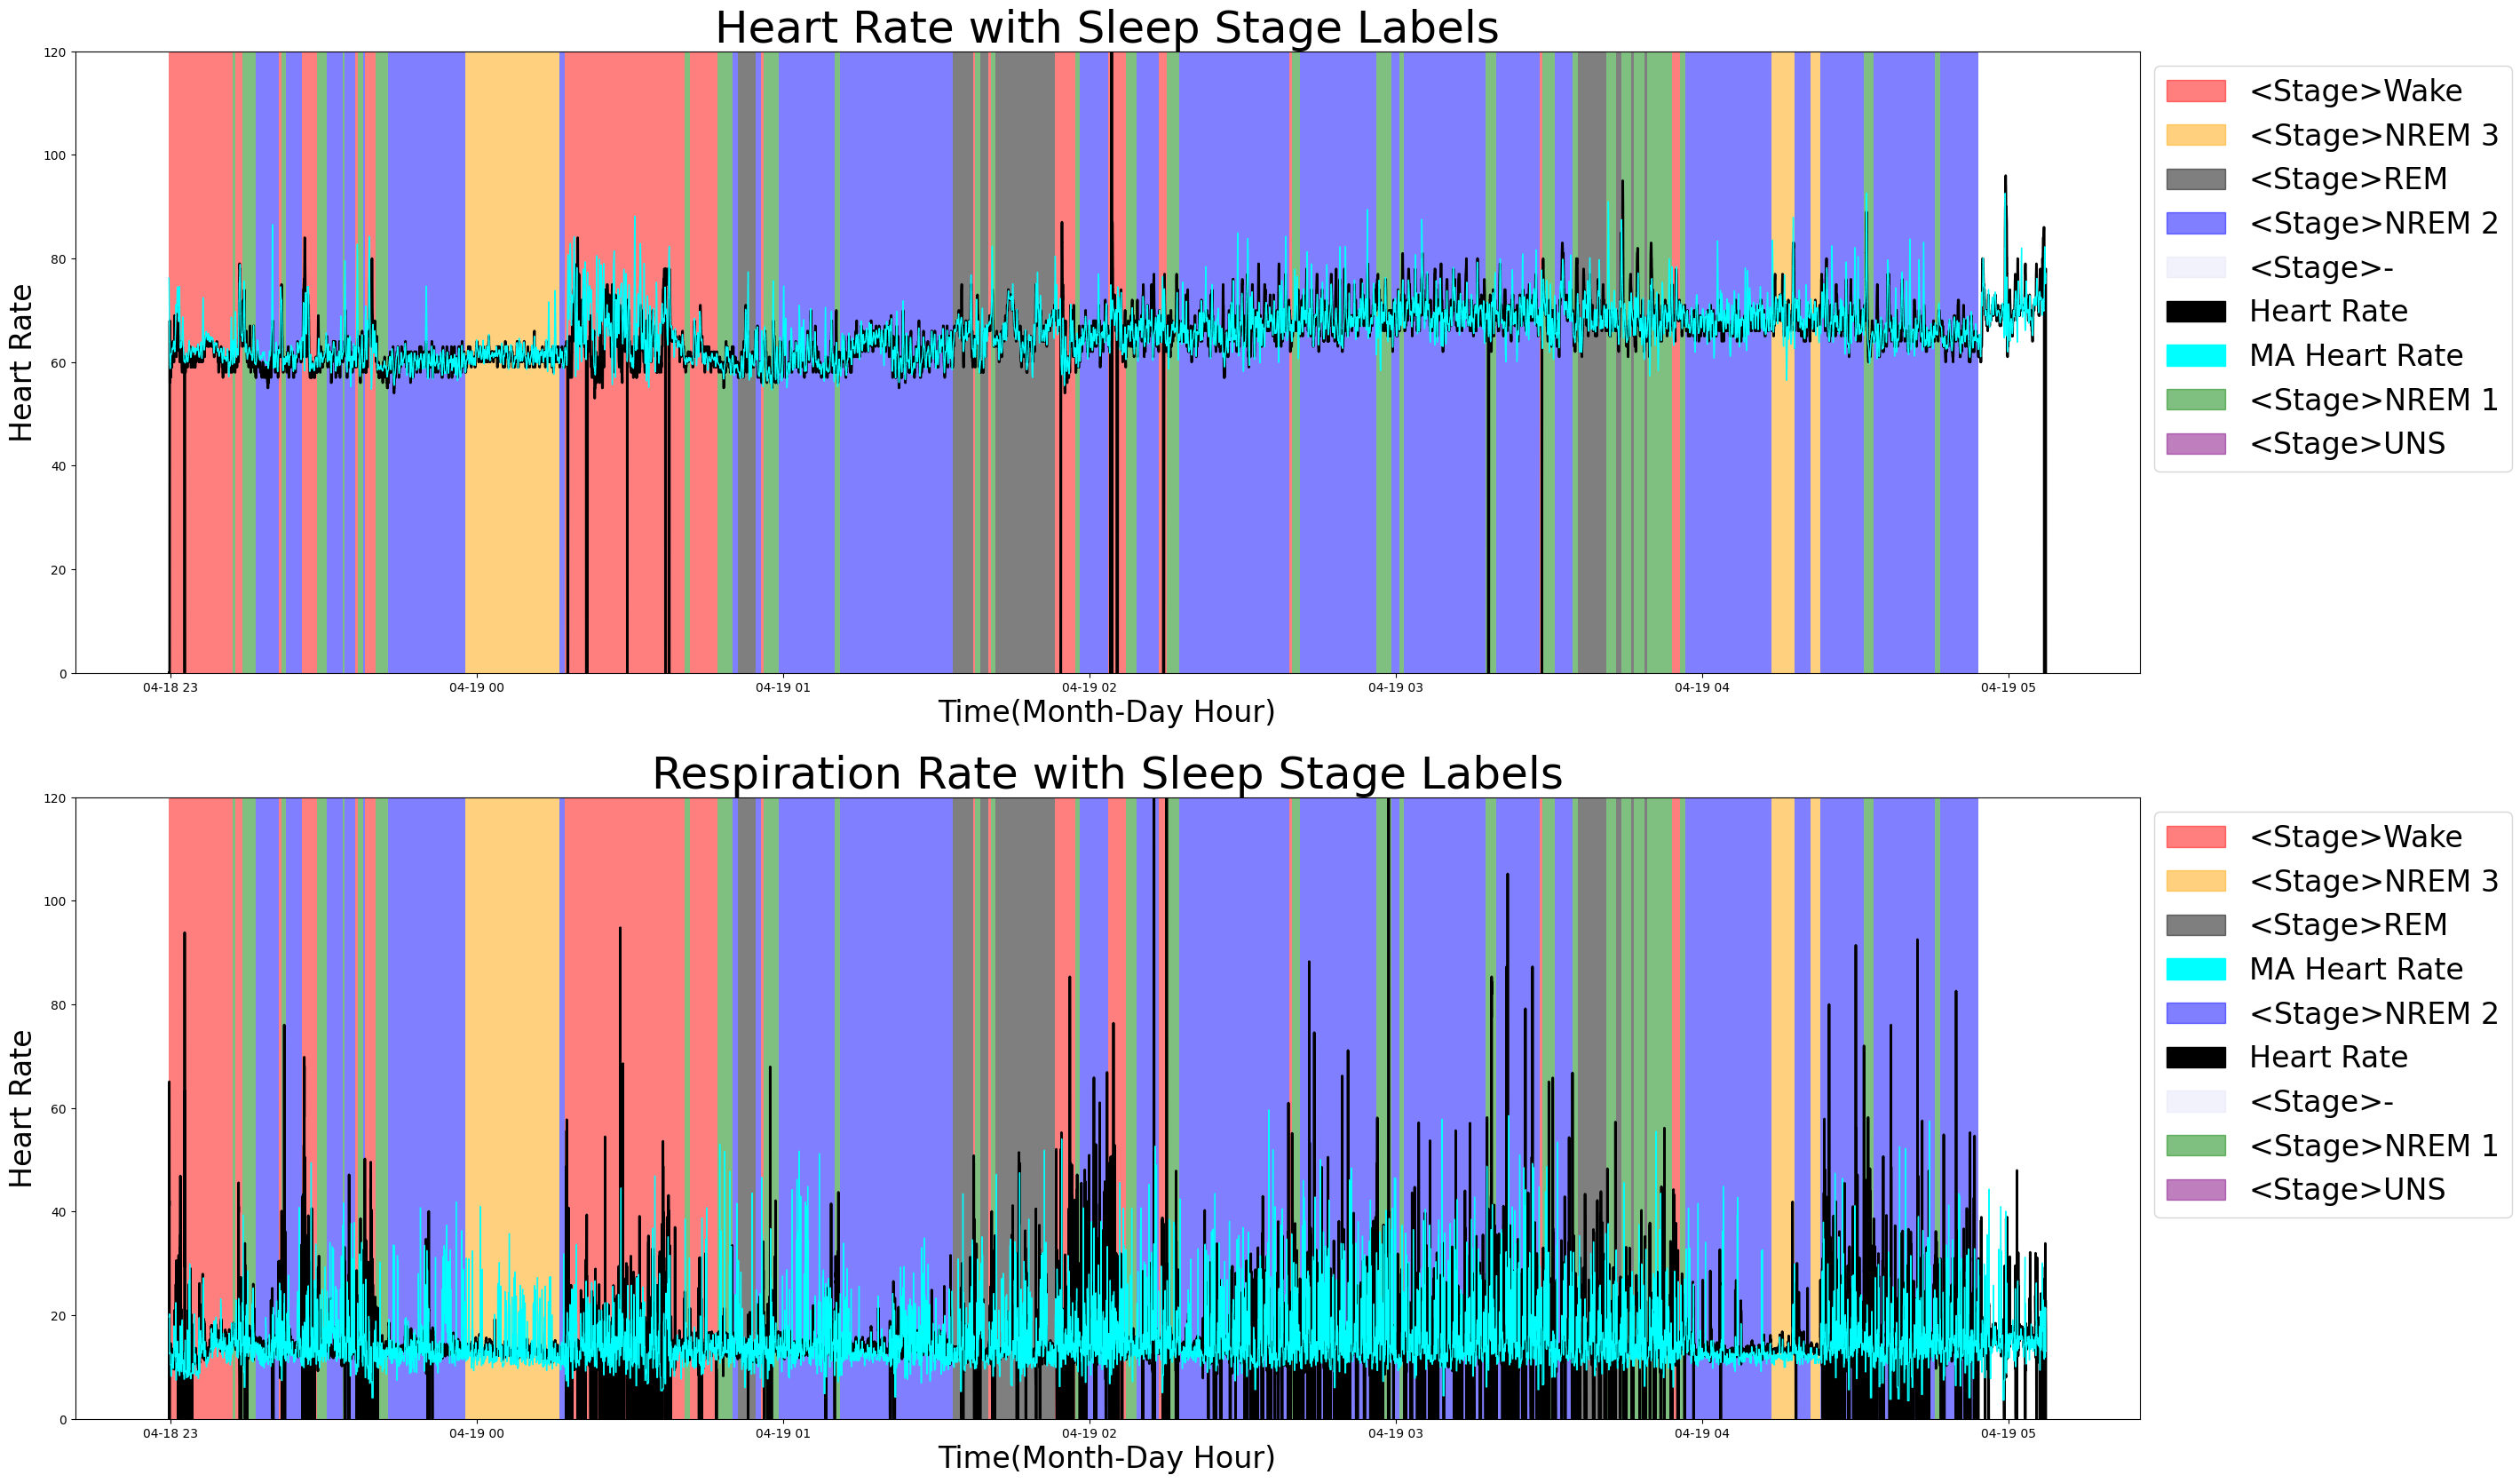

In [22]:

test_plot_labeled_dataframe(final_df.dropna())

In [10]:
final_df.dropna()

,x,y,z,ma_hr,resp_orientation,ma_rr,PR,RR,Stage,Epoch,QuantizedStage
2023-04-18 22:59:38.000,-16.5,1527.0,8016.5,76.211122,0.116476,19.646365,0.0,0.006104,<Stage>Wake,<Epoch>1,0
2023-04-18 22:59:38.001,-17.0,1527.0,8060.0,76.211122,0.116446,19.646365,0.0,0.006104,<Stage>Wake,<Epoch>1,0
2023-04-18 22:59:38.002,-17.0,1527.0,8037.5,76.211122,0.116416,19.646365,0.0,0.006104,<Stage>Wake,<Epoch>1,0
2023-04-18 22:59:38.003,-17.0,1527.0,8008.5,76.211122,0.116386,19.646365,0.0,0.006104,<Stage>Wake,<Epoch>1,0
2023-04-18 22:59:38.004,-17.0,1527.0,8014.0,76.211122,0.116356,19.646365,0.0,0.006104,<Stage>Wake,<Epoch>1,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-19 05:07:14.994,5240.0,-2210.0,5940.0,77.127165,0.299758,13.057671,0.0,0.006104,<Stage>Wake,<Epoch>735,0
2023-04-19 05:07:14.995,5240.0,-2209.0,5956.0,77.127165,0.299734,13.057671,0.0,0.006104,<Stage>Wake,<Epoch>735,0
2023-04-19 05:07:14.996,5240.0,-2208.0,5963.0,77.127165,0.299710,13.057671,0.0,0.006104,<Stage>Wake,<Epoch>735,0
2023-04-19 05:07:14.997,5240.0,-2207.0,5960.0,77.127165,0.299686,13.057671,0.0,0.006104,<Stage>Wake,<Epoch>735,0


In [11]:
ret

,x,y,z,ma_hr,resp_orientation,ma_rr
t,,,,,,
2023-04-30 08:28:59.200,65.0,-3776.0,7197.0,72.079530,-0.850384,18.275967
2023-04-30 08:28:59.201,65.0,-3776.0,7197.0,72.079530,-0.850361,18.275967
2023-04-30 08:28:59.202,65.0,-3776.0,7197.0,72.079530,-0.850338,18.275967
2023-04-30 08:28:59.203,65.0,-3776.0,7197.0,72.079530,-0.850316,18.275967
2023-04-30 08:28:59.204,65.0,-3776.0,7197.0,72.079530,-0.850293,18.275967
...,...,...,...,...,...,...
2023-04-30 14:59:59.917,7862.0,-1886.0,1403.0,41.953958,0.364310,18.055974
2023-04-30 14:59:59.918,7862.0,-1886.0,1357.0,41.953958,0.364310,18.055974
2023-04-30 14:59:59.919,7862.0,-1886.0,1383.0,41.953958,0.364310,18.055974


In [6]:
phi.shape

(23460701, 1)

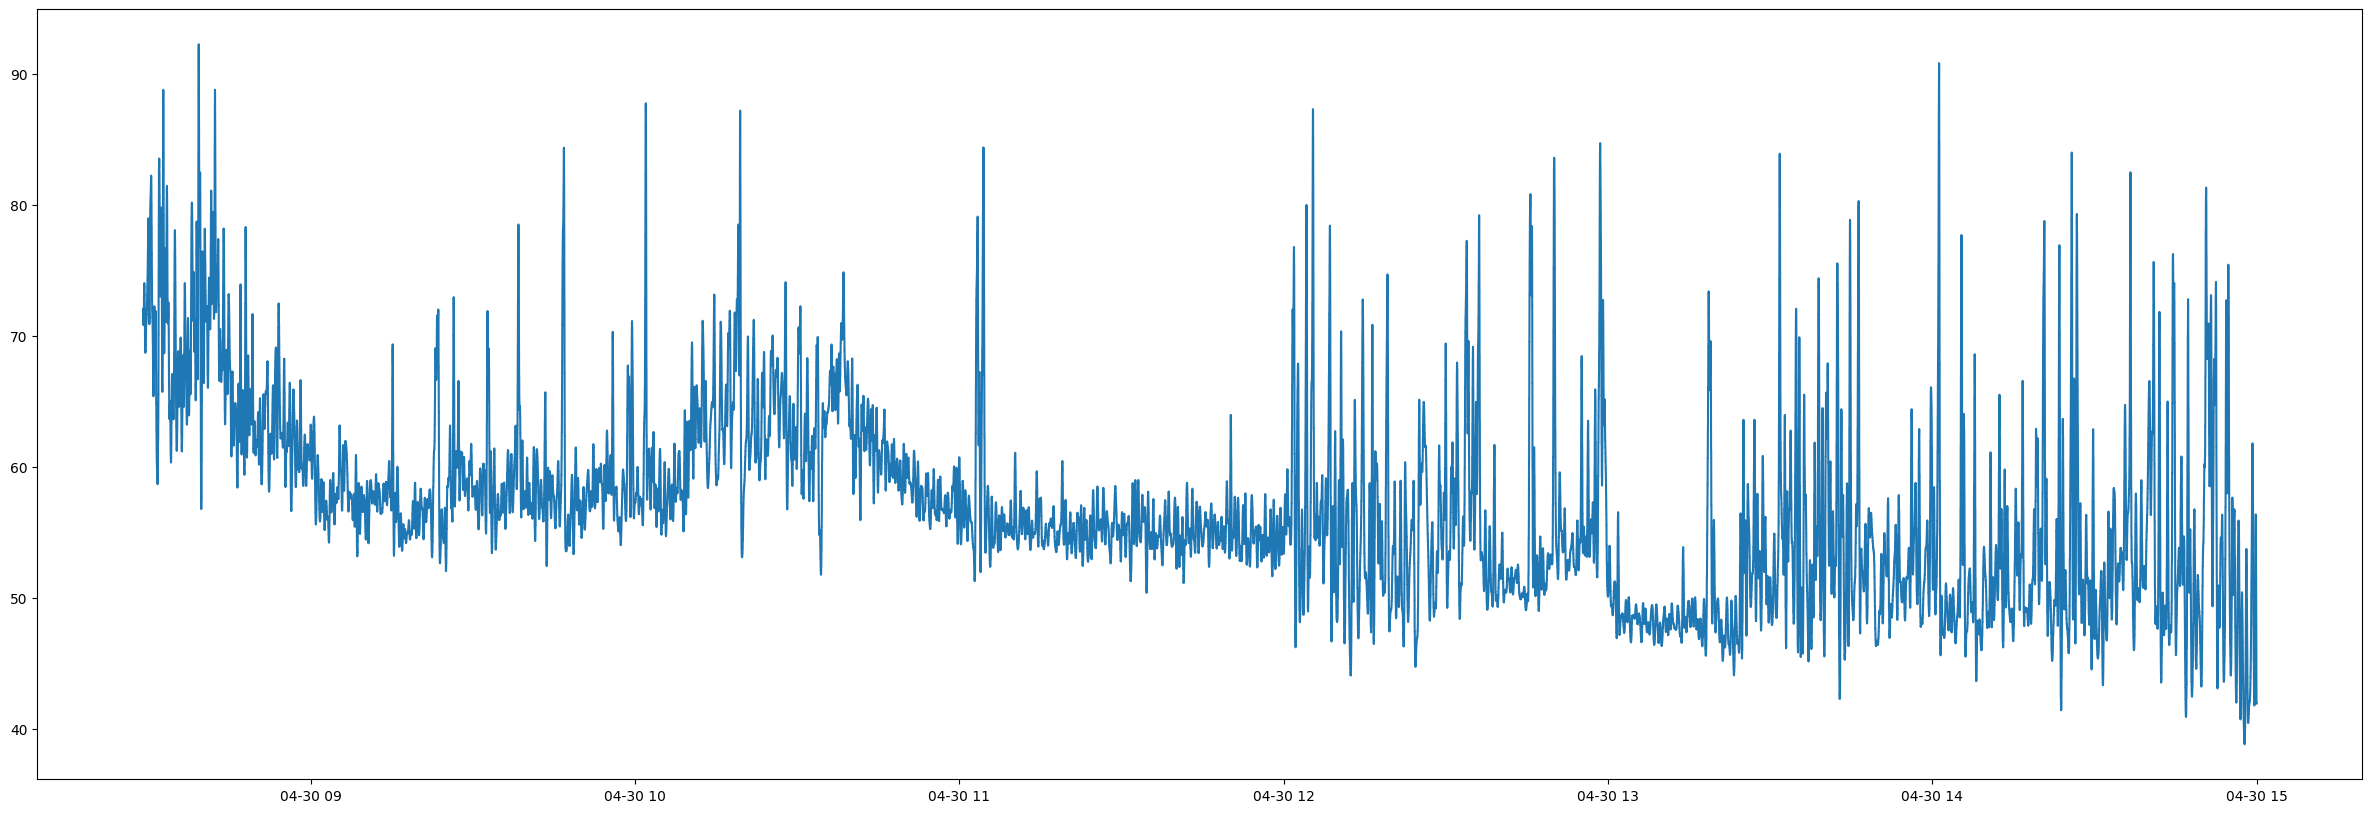

In [6]:
plt.figure(figsize=(30, 10))
plt.plot(ret['ma_hr'])

In [12]:
import pandas as pd
# for f in filelist:

for i in range(9):
    csv = pd.read_csv(f'../rawdata/patient0{i+1}.csv')
    csv = csv.rename(columns={'ts':'t'})
    csv.to_parquet(f'../rawdata/patient0{i+1}.parquet')

In [9]:
csv.rename(columns={'ts':'t'})

,t,x,y,z
0,2023-04-18T01:53:05.053474,330,-8212,758
1,2023-04-18T01:53:05.054082,329,-8212,799
2,2023-04-18T01:53:05.054690,329,-8212,793
3,2023-04-18T01:53:05.055298,329,-8212,750
4,2023-04-18T01:53:05.055906,329,-8212,757
...,...,...,...,...
45191745,2023-04-18T09:33:17.888412,-6930,3487,2458
45191746,2023-04-18T09:33:17.889025,-6930,3487,2465
45191747,2023-04-18T09:33:17.889638,-6930,3487,2475
45191748,2023-04-18T09:33:17.890251,-6930,3487,2487
